# Mel-Frequency Cepstral Coefficients (MFCC)

Neste notebook, vamos realizar um breve estudo e implementação do MFCC, uma técnica poderosa de processamento de sinal e extração de features para áudio e fala. Na era do Deep Learning, ela caiu um pouco em desuso, mas ainda é uma técnica relevante quando utilizada em conjunto com algoritmos clássicos de Machine Learning. Algumas aplicações: reconhecimento de fala, análise de música, análise/detecção de sentimento, entre outras.

In [1]:
import os

from IPython.display import display
from PIL import Image

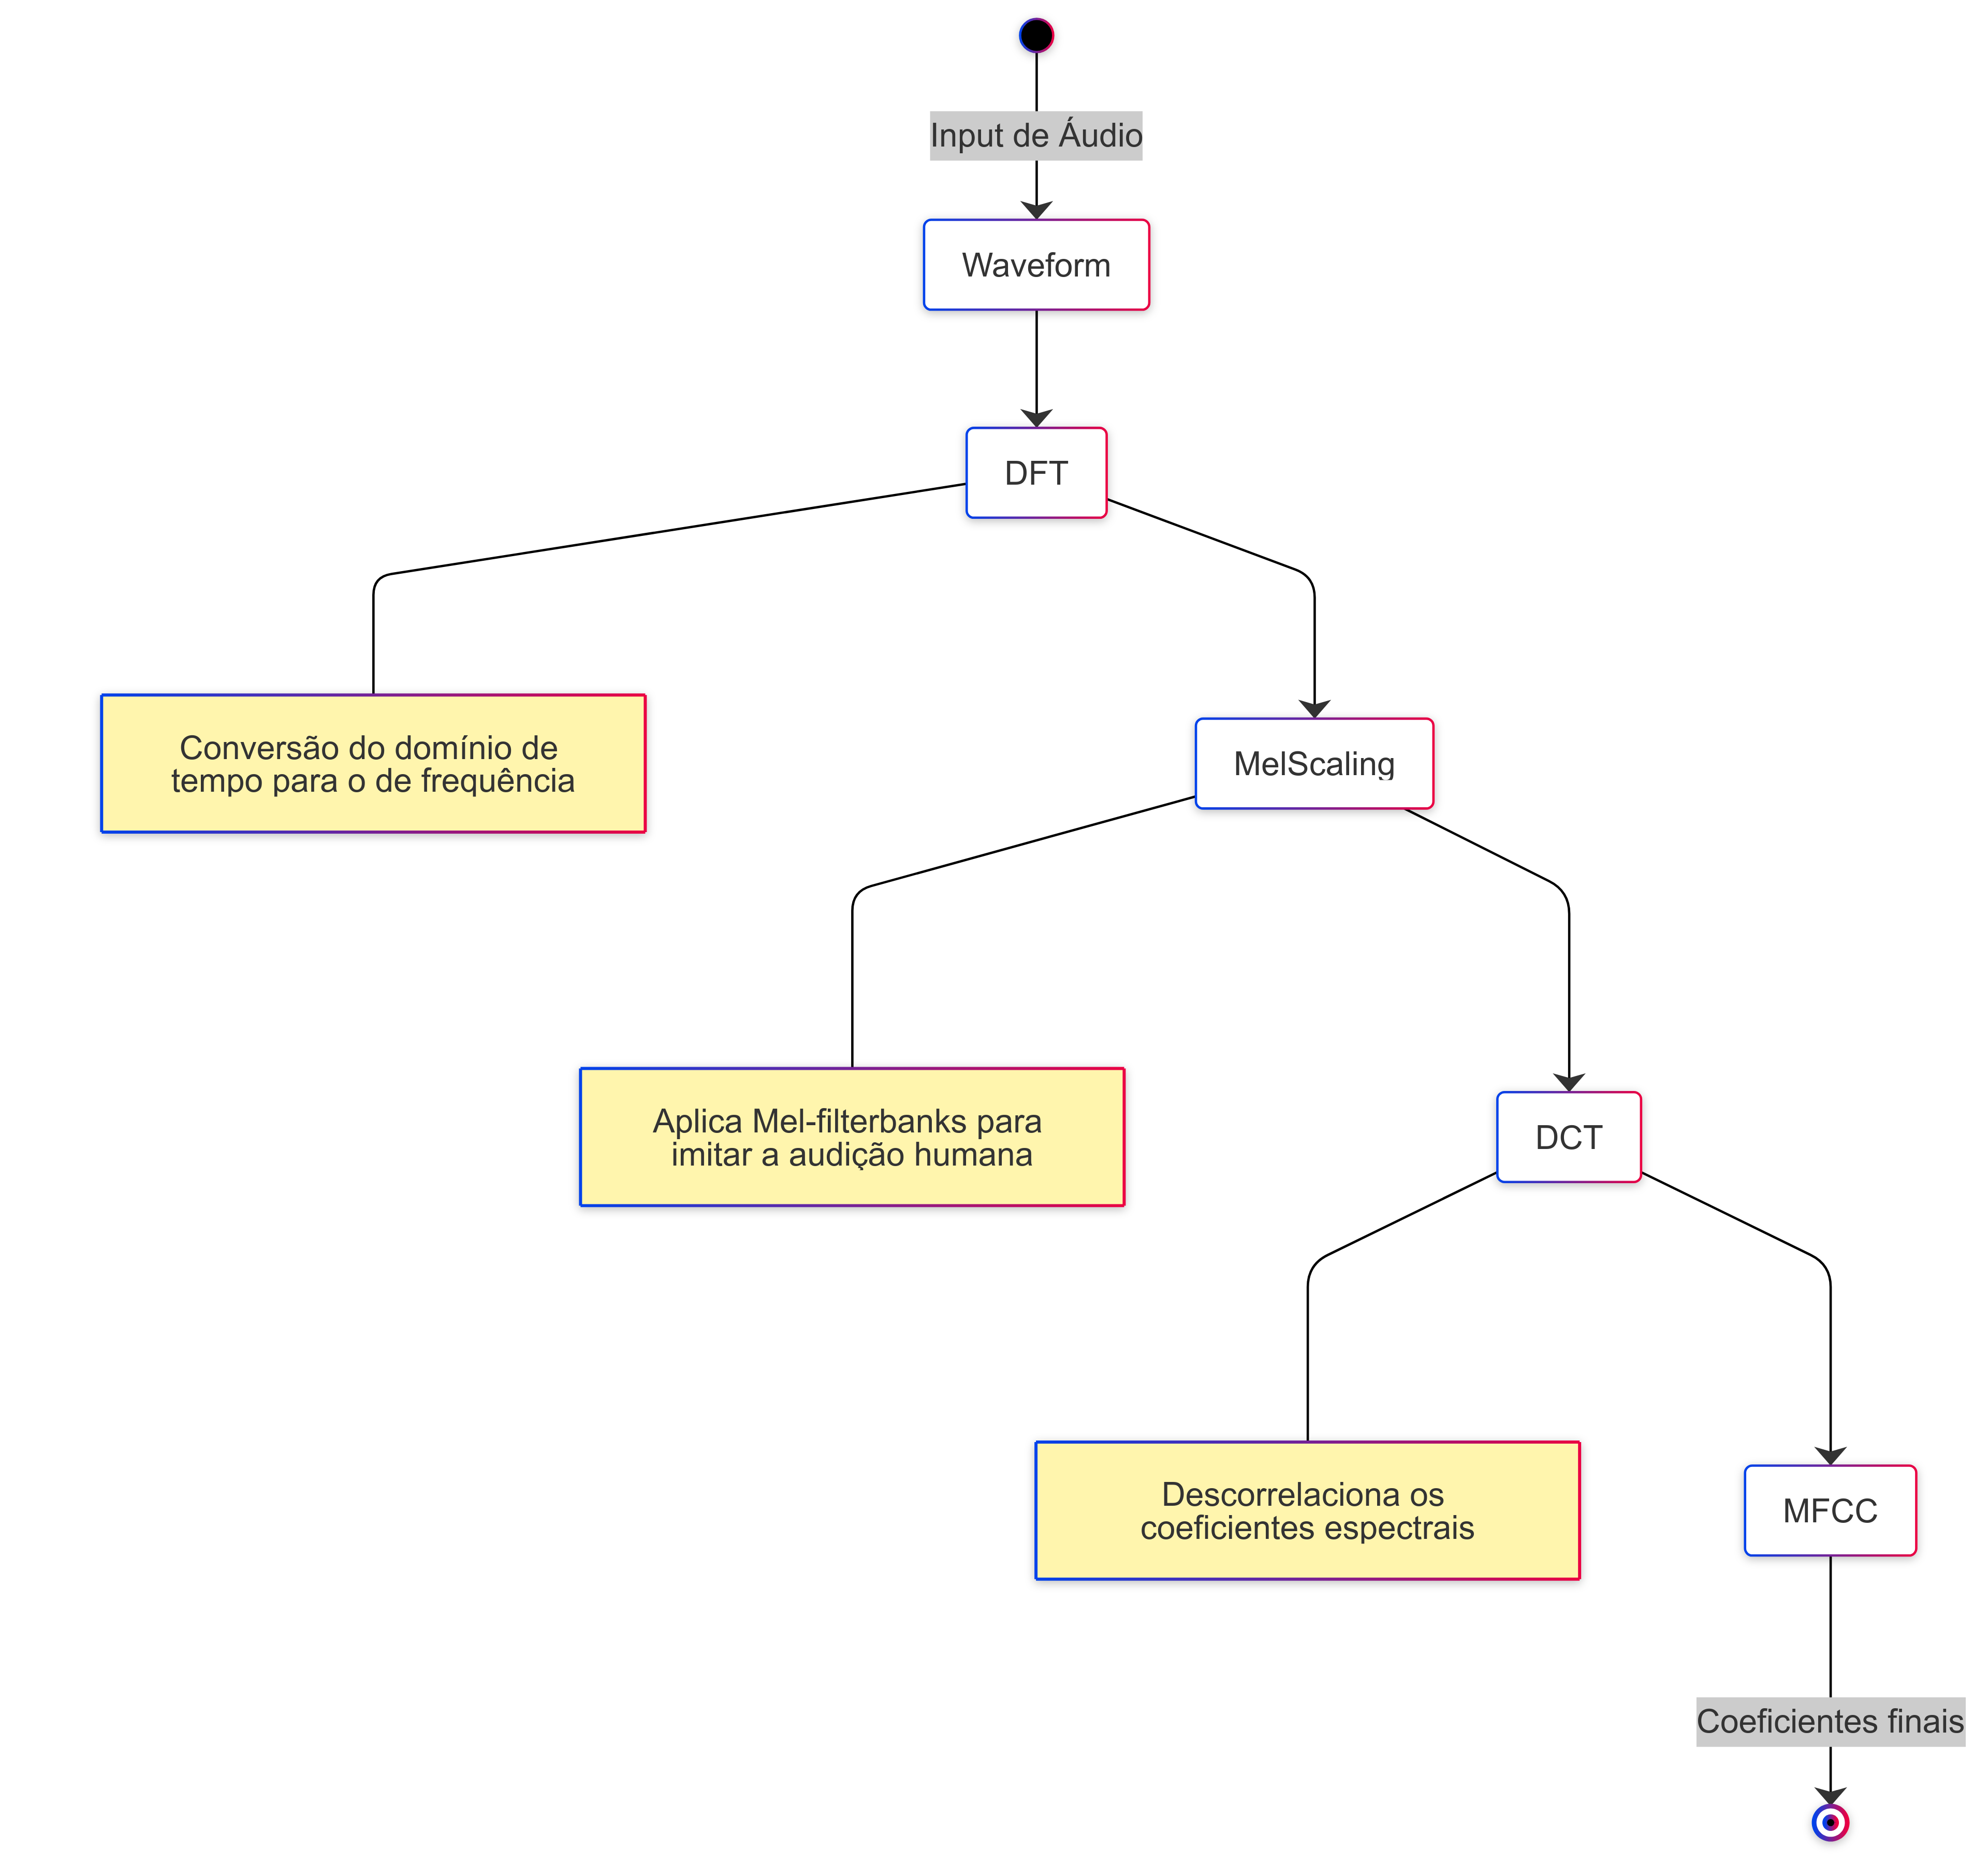

In [2]:
path = os.path.join(os.path.dirname(os.getcwd()), 'images', 'graph.png')

with Image.open(path) as i:
	display(i)

# 1. Visualização do áudio em waveform

In [3]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

In [4]:
major_scale_file = os.path.join(os.path.dirname(os.getcwd()), 'sample_audio_files', 'scale.wav')
Audio(major_scale_file)

In [5]:
signal, sampling_rate = librosa.load(major_scale_file)
print(f"Forma do sinal: {signal.shape}.\nSampling rate: {sampling_rate} Hz.")

Forma do sinal: (174943,).
Sampling rate: 22050 Hz.


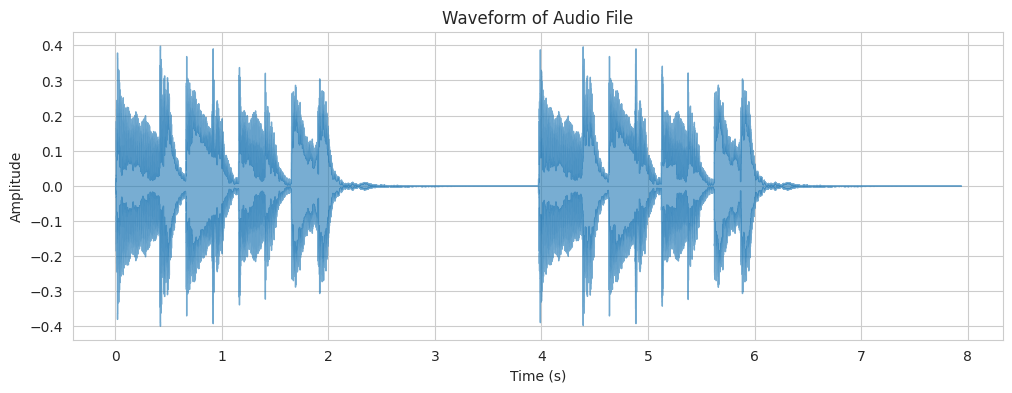

In [6]:
# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sampling_rate, alpha=0.6)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio File")
plt.show()

# 2. Discrete Fourier Transform (DFT)

Essa é a versão discreta da Transformada de Fourier. A ideia aqui é processar um sinal que originalmente é uma função do tempo, e desmembrá-lo em componentes de frequência. Com isso, podemos observar quanto cada faixa de frequência contribui na construção do sinal todo.

## 2.1 Sobre o sinal inteiro

In [7]:
import numpy as np
import seaborn as sns

In [8]:
signal_ft = np.fft.fft(signal)
magnitude_spectrum = np.abs(signal_ft)
print(f"Forma do array de coeficientes de Fourier: {signal_ft.shape}.")

Forma do array de coeficientes de Fourier: (174943,).


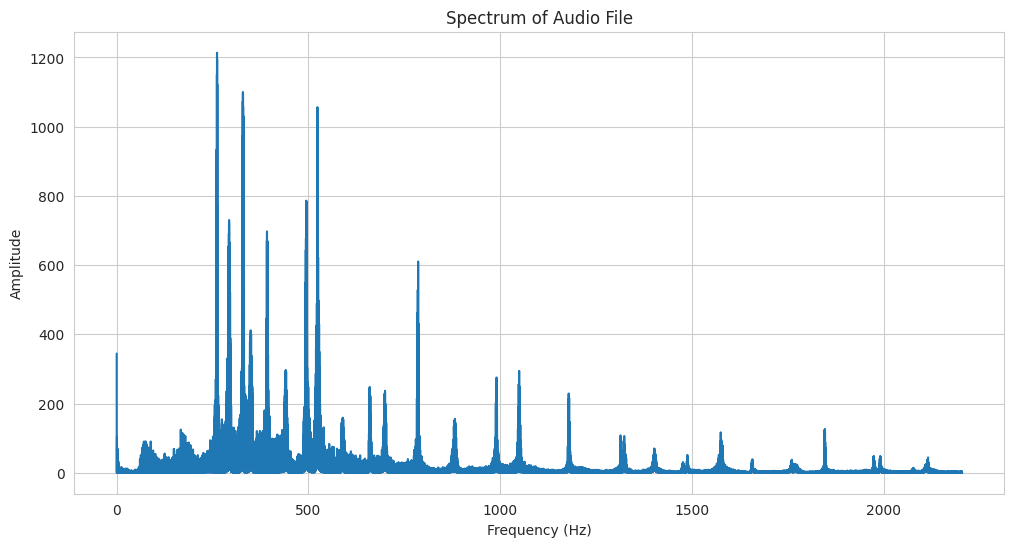

In [9]:
frequency = np.linspace(0, sampling_rate, len(signal))
frequency_ratio = 0.1
num_frequency_bins = int(len(frequency) * frequency_ratio)

plt.figure(figsize=(12, 6))
plt.plot(frequency[:num_frequency_bins], magnitude_spectrum[:num_frequency_bins]);
plt.xlabel("Frequency (Hz)");
plt.ylabel("Amplitude");
plt.title("Spectrum of Audio File");

## 2.2 Short-time Fourier Transform

Na STFT, o que muda é que quebramos o sinal em pequenas janelas (frames) e aplicamos a DFT sobre cada uma delas. Normalmente, cada janela tem um overlap com as adjacentes.

In [10]:
# tamanho da janela
FRAME_SIZE = 2048

# tamanho do descolamento para início da próxima janela
HOP_SIZE = 512

Extração e transformação dos coeficientes da STFT.

In [11]:
stft_coefficients = librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

# amplitude ao quadrado (power)
stft_amplitude_squared = np.abs(stft_coefficients)**2

# tomando o log do quadrado das amplitudes
log_stft_amplitude_squared = librosa.power_to_db(stft_amplitude_squared)

In [12]:
print(f"Dimensões: {log_stft_amplitude_squared.shape}.")

Dimensões: (1025, 342).


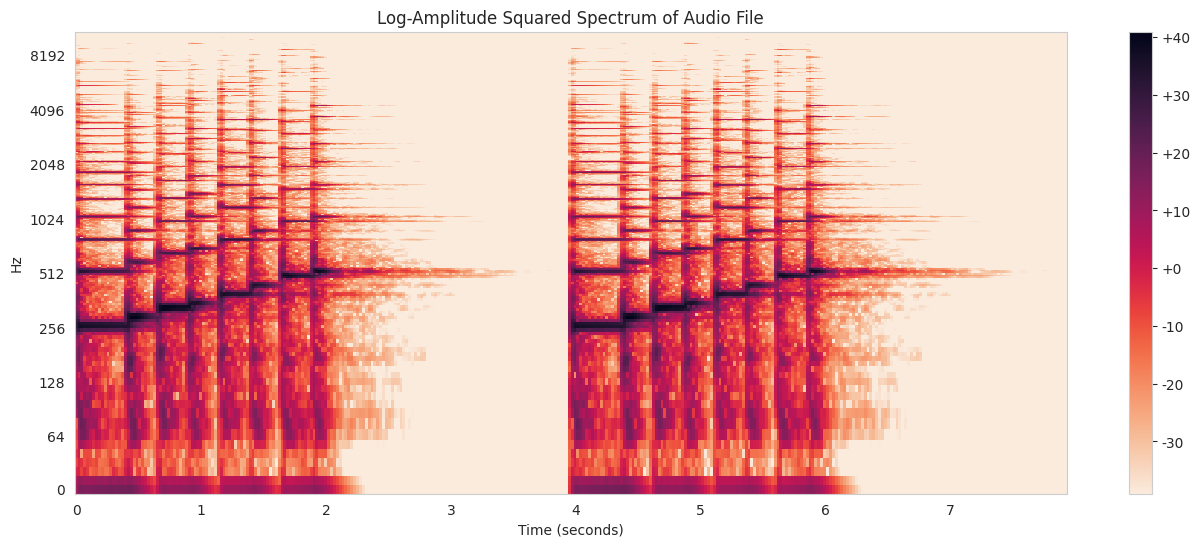

In [13]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(log_stft_amplitude_squared,
                         sr=sampling_rate,
                         hop_length=HOP_SIZE,
                         x_axis="s",
                         y_axis="log",
                         cmap='rocket_r',);

plt.colorbar(format="%+2.f");
plt.title("Log-Amplitude Squared Spectrum of Audio File");

# 3. Mel Scaling

Uma vez que obtivemos o espectrograma, criamos os chamados Mel filter banks para aplicá-los sobre este. A ideia deste tipo de filtragem e fazer com que tenhamos features mais "perceptualmente" informados. Para criá-los, seguimos os seguintes passos:

1. convertemos o range de frequência do espectrograma para a escala Mel, dada por
    $$ m = 2595log(1 + f/500) $$
   Tal fórmula foi empiricamente obtida de forma a modelar como a audição humana percebe frequências.
2. selecionamos N pontos igualmente espaçados nesse range, em que N é o número escolhido de filter banks;
3. criamos os filter banks triangulares cujos centros são os pontos determinados no passo anterior;
4. por fim, aplicamos o filtro sobre o espectrograma.

O conjunto de todos estes bancos define o filtro todo.

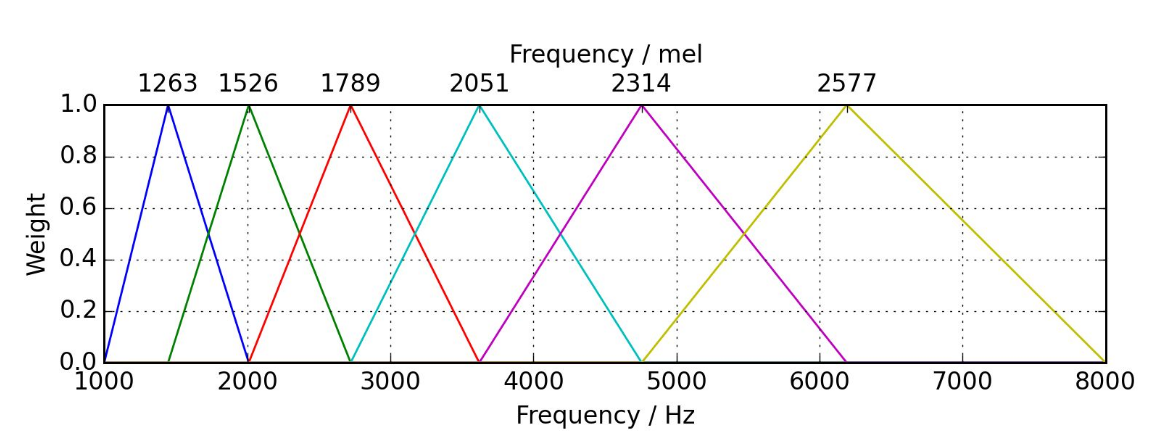

In [14]:
path = os.path.join(os.path.dirname(os.getcwd()), 'images', 'mel_filterbanks.png')

with Image.open(path) as i:
	display(i)

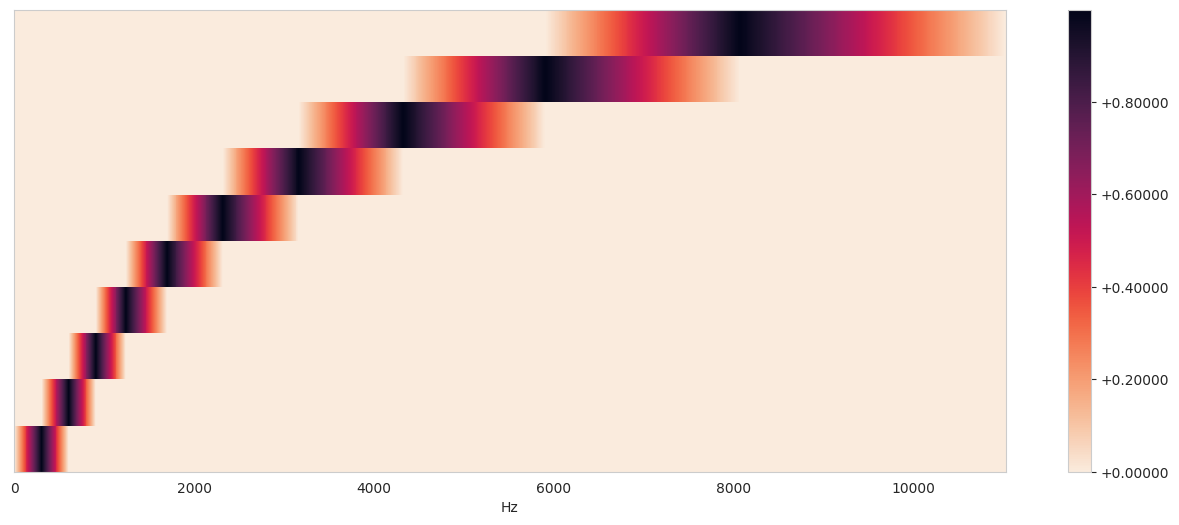

In [15]:
# construindo os Mel filterbanks
filter_banks = librosa.filters.mel(n_fft=FRAME_SIZE,
                                   sr=sampling_rate,
                                   n_mels=10,
                                   norm=None)

plt.figure(figsize=(16, 6))
librosa.display.specshow(filter_banks,
                         sr=sampling_rate,
                         x_axis="linear",
                         cmap='rocket_r')

plt.colorbar(format="%+0.5f");
plt.show()

## 3.1 Aplicação dos Mel filter banks

Note as dimensões das matrizes do espectrograma e dos filter banks, respectivamente.

In [16]:
print(f'Dimensões dos filter banks: {filter_banks.shape}.')
print(f'Dimensões do espectrograma: {log_stft_amplitude_squared.shape}.')

Dimensões dos filter banks: (10, 1025).
Dimensões do espectrograma: (1025, 342).


Assim, para obter o espectrograma Mel, basta fazermos a multiplicação matricial
 $$Mel\_spectrogram = MY$$
 em que M é a matriz do filtro e Y a matriz do espectograma.

### 3.1.1 Multiplicação "manual"

In [17]:
filter_banks = librosa.filters.mel(n_fft=FRAME_SIZE,
                                   sr=sampling_rate,
                                   n_mels=40)

mel_spectrogram_manual = np.matmul(filter_banks, stft_amplitude_squared)

In [18]:
log_mel_spectrogram_manual = librosa.power_to_db(mel_spectrogram_manual)

In [19]:
print(f"Dimensão do espectrograma Mel: {log_mel_spectrogram_manual.shape}")

Dimensão do espectrograma Mel: (40, 342)


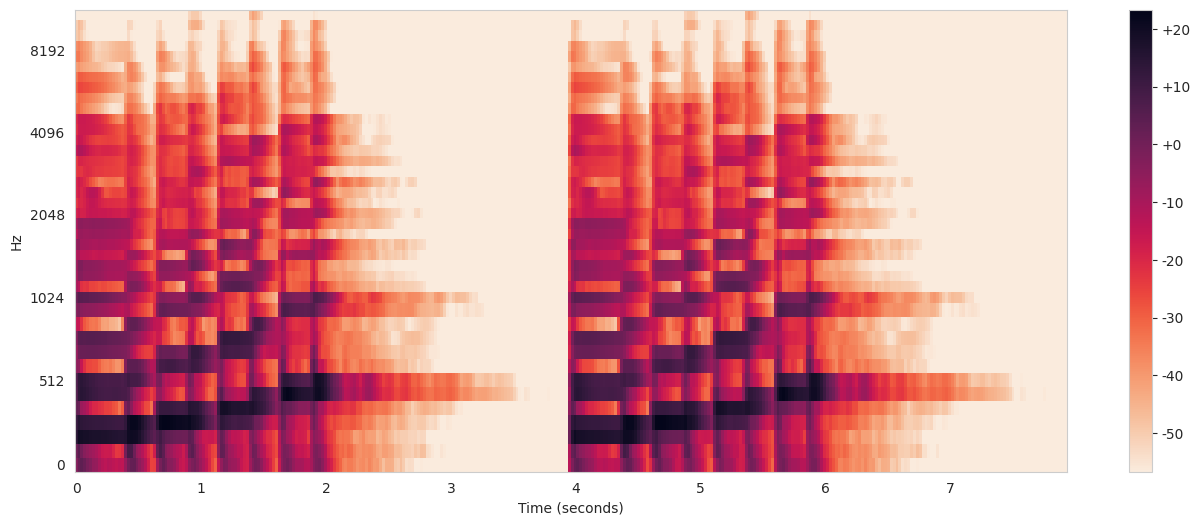

In [20]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(log_mel_spectrogram_manual,
                         x_axis="s",
                         y_axis="mel",
                         sr=sampling_rate,
                         cmap='rocket_r')

plt.colorbar(format="%+2.f")
plt.show()

### 3.1.2 Implementação pronta

In [21]:
mel_spectrogram = librosa.feature.melspectrogram(y=signal,
                                                 sr=sampling_rate,
                                                 n_fft=FRAME_SIZE,
                                                 hop_length=HOP_SIZE,
                                                 n_mels=40)

In [22]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

In [23]:
print(f"Dimensão do espectrograma Mel: {log_mel_spectrogram.shape}")

Dimensão do espectrograma Mel: (40, 342)


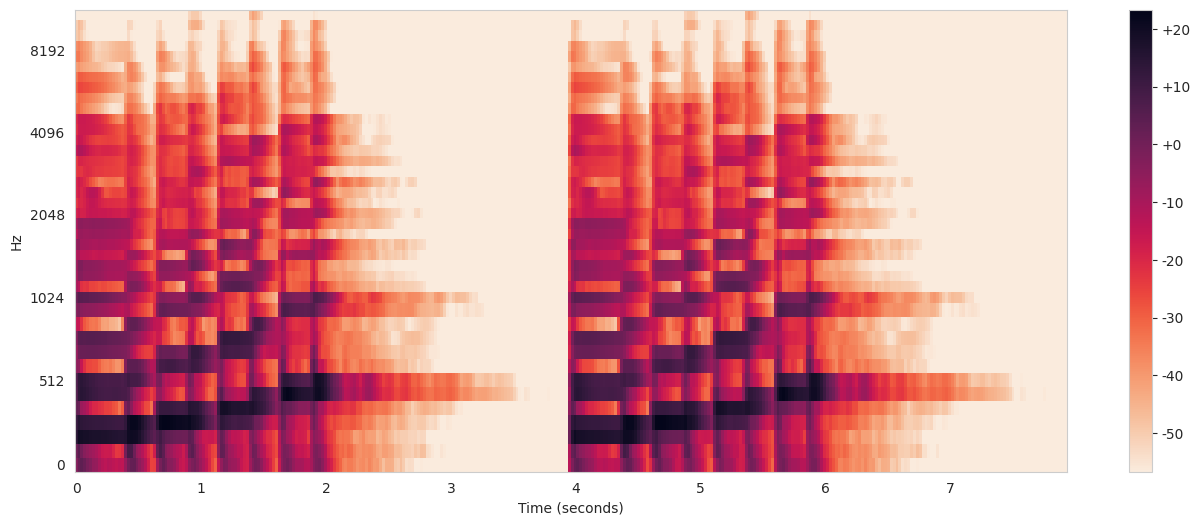

In [24]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(log_mel_spectrogram,
                         x_axis="s",
                         y_axis="mel",
                         sr=sampling_rate,
                         cmap='rocket_r')

plt.colorbar(format="%+2.f")
plt.show()

# 4. Discrete Cosine Transform

Por último, temos mais uma transformação para obter os MFCCs, a Transformada de Cosseno Discreta. Trata-se de uma versão simplificada da Transformada de Fourier. Algumas características:

- Retorna valores reais e não complexos.
- Descorrelaciona os Mel bands (filterbanks).
- Reduz a dimensionalidade do espectrograma Mel.

O ponto último ponto é extremamente valioso para algoritmos clássicos de Machine Learning. <br>
Além dos próprios MFCCs, é comum usar a primeira e a segunda derivada destes também.

In [25]:
import scipy.fftpack

mfcc_full_features = scipy.fftpack.dct(log_mel_spectrogram,
                                       type=2,
                                       axis=0,
                                       norm='ortho')

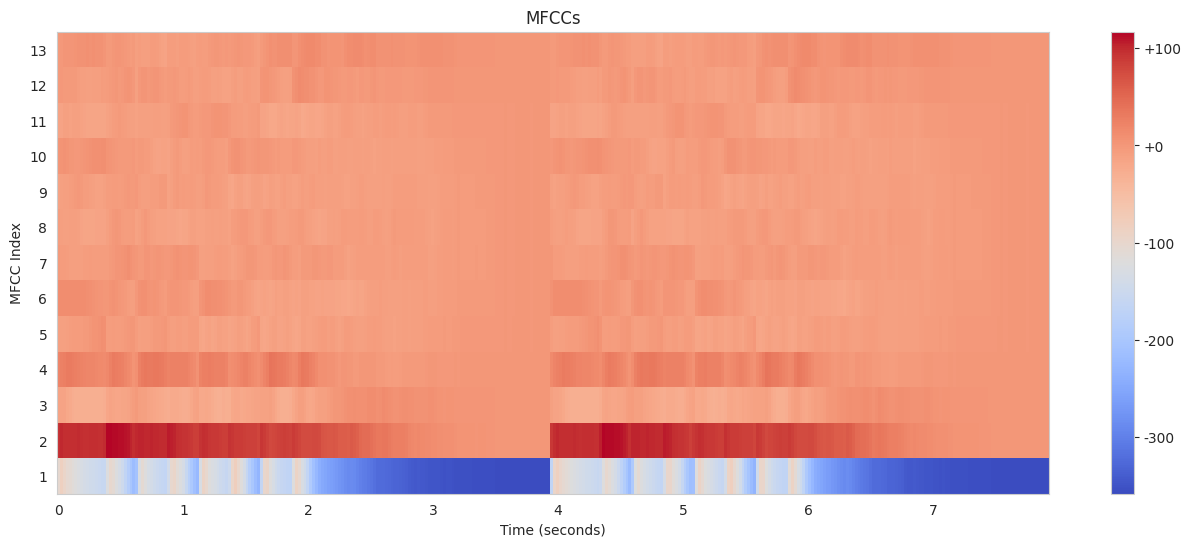

In [26]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(mfcc_full_features[0:13],
                         x_axis="s",
                         sr=sampling_rate)

plt.yticks(ticks=np.arange(13), labels=np.arange(1, 14))
plt.title("MFCCs");
plt.ylabel("MFCC Index");

plt.colorbar(format="%+2.f")
plt.show()

# 5. MFCCs


Por fim, mostramos como utilizar a implementação pronta do Librosa para obter os coeficientes MFCC. O fluxo apresentado é inteiramente executado pela função abaixo. <br>
Vale notar que, na literatura, usualmente escolhemos somente os 13 primeiros coeficientes.

In [27]:
mfcc_features = librosa.feature.mfcc(y=signal,
                                     sr=sampling_rate,
                                     n_mfcc=13,
                                     n_fft=FRAME_SIZE,
                                     hop_length=HOP_SIZE,
                                     n_mels=40)

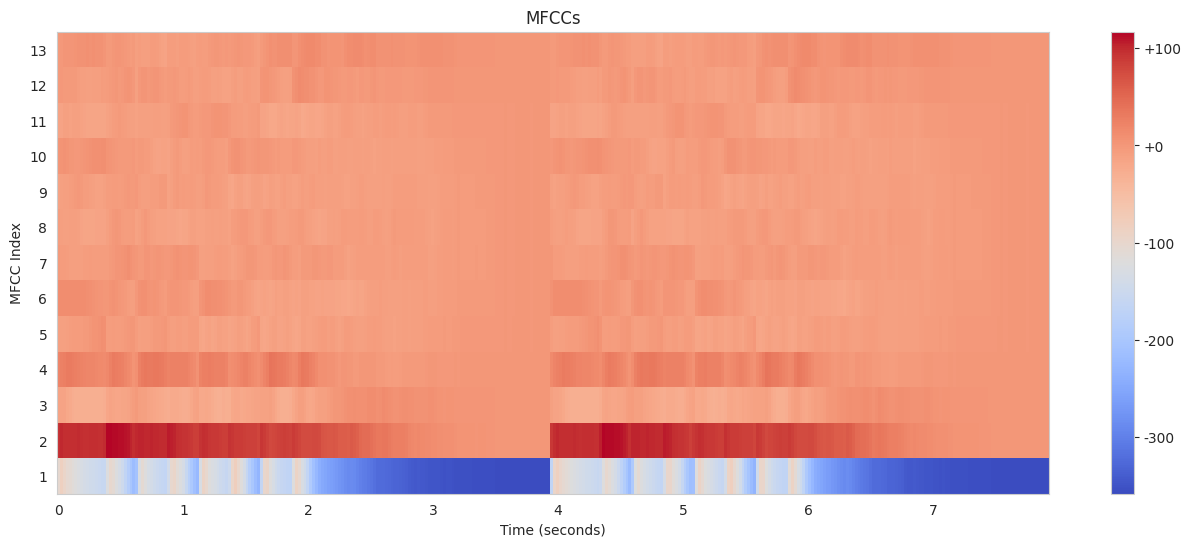

In [28]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(mfcc_features,
                         x_axis="s",
                         sr=sampling_rate)

plt.yticks(ticks=np.arange(13), labels=np.arange(1, 14))
plt.title("MFCCs");
plt.ylabel("MFCC Index");

plt.colorbar(format="%+2.f")
plt.show()

## 5.2 Primeira e segunda derivadas dos MFCCs

In [29]:
# primeira derivada
delta_mfcc_features = librosa.feature.delta(mfcc_features)

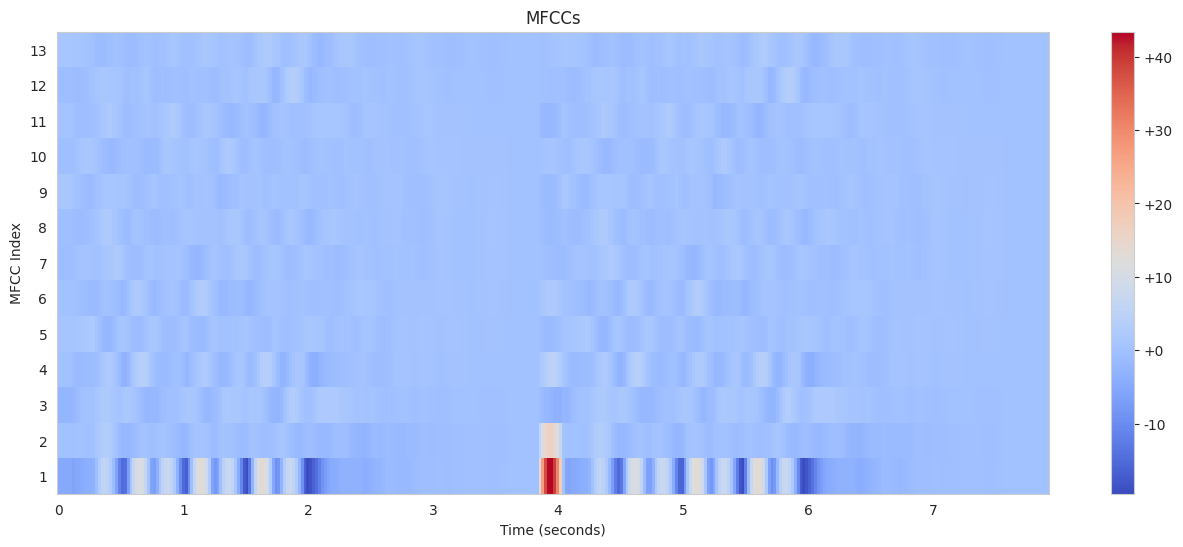

In [30]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(delta_mfcc_features,
                         x_axis="s",
                         sr=sampling_rate)

plt.yticks(ticks=np.arange(13), labels=np.arange(1, 14))
plt.title("MFCCs");
plt.ylabel("MFCC Index");

plt.colorbar(format="%+2.f")
plt.show()

In [31]:
# segunda derivada
delta_delta_mfcc_features = librosa.feature.delta(mfcc_features, order=2)

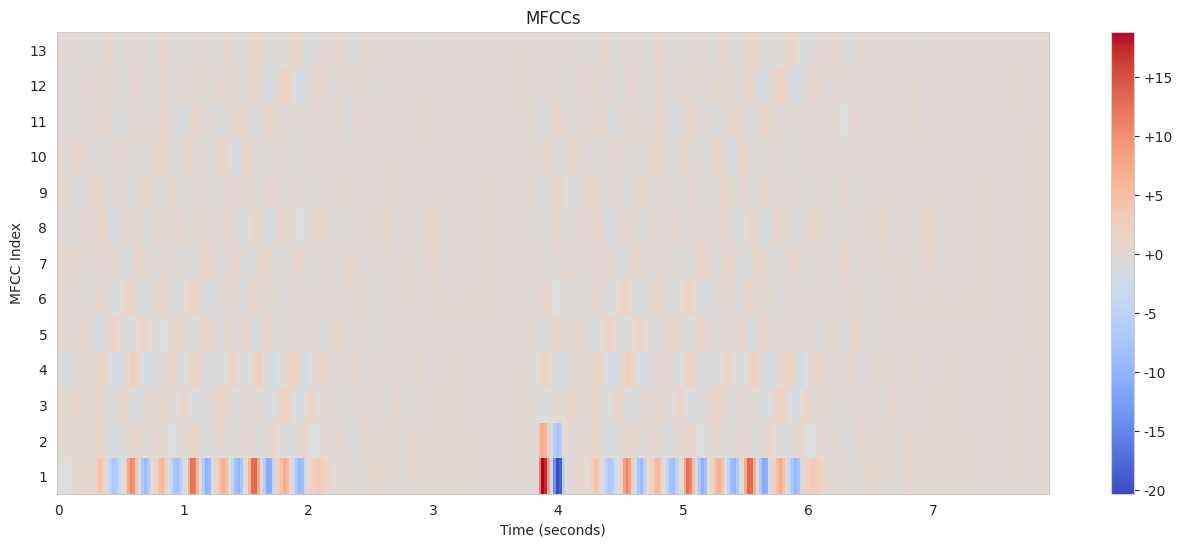

In [32]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(delta_delta_mfcc_features,
                         x_axis="s",
                         sr=sampling_rate)

plt.yticks(ticks=np.arange(13), labels=np.arange(1, 14))
plt.title("MFCCs");
plt.ylabel("MFCC Index");

plt.colorbar(format="%+2.f")
plt.show()

Extraídos os MFCCs, o modo como eles são usados e inputados em um modelo vai depender da aplicação em questão. A seguir, algumas estratégias possíveis.
1. Usá-los de modo cru. Para isso, transformamos a matrix inteira em um único vetor unidimensional. Tal abordagem é melhor pareada com modelos clássicos como SVM ou então MLPs tradicionais. Uma das desvantagens é que nós perdemos a dinâmica temporal codificada nos coeficientes, além da alta dimensionalidade.
2. Extrair estatísticas básicas de cada uma das séries dos coeficientes. Essa estratégia funciona bem com áudios curtos, porém sofre do mesmo problema da abordagem anterior, já que estatísticas simples falham em capturar dinâmicas complexas.
3. Separar os coeficientes em séries temporais e aplicar modelos que tratam isso como, por exempo, LSTM e TCNs.
4. Tratar a matrix toda como uma "imagem", e dimensioná-las para uso em modelos baseados em Redes Neurais Convolucionais.

# Bônus

Demonstração do uso de MFCCs em um problema de classificação. Aqui, utilizamos trechos de áudio de sons produzidos por gatos e cachorros, e treinamos um classificador que seja capaz de distinguir entre os dois tipos de som. <br> A implementação é totalmente devida ao repositório: https://github.com/FilipTirnanic96/mfcc_extraction

Como reportador pelo autor, os passos seguidos para a tarefa foram os seguintes:

1. Carregar os dados de treinamento e teste
2. Preencher os dados para terem o mesmo comprimento
3. Extrair MFCCs dos dados
4. Reduzir a dimensionalidade para 30 componentes usando PCA
5. Treinar e testar um classificador usando Regressão Logística

In [33]:
cat_train_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'train', 'cat')
dog_train_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'train', 'dog')

In [34]:
sample_cat_audio_file = os.path.join(cat_train_path, 'cat_10.wav')
Audio(sample_cat_audio_file)

In [35]:
sample_dog_audio_file = os.path.join(dog_train_path, 'dog_barking_2.wav')
Audio(sample_dog_audio_file)

Train classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95       125
         1.0       0.97      0.86      0.91        85

    accuracy                           0.93       210
   macro avg       0.94      0.92      0.93       210
weighted avg       0.94      0.93      0.93       210

Test classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91        39
         1.0       0.89      0.86      0.87        28

    accuracy                           0.90        67
   macro avg       0.89      0.89      0.89        67
weighted avg       0.90      0.90      0.90        67



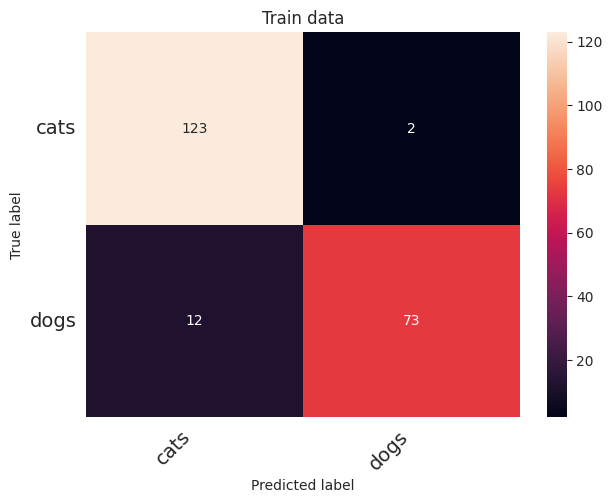

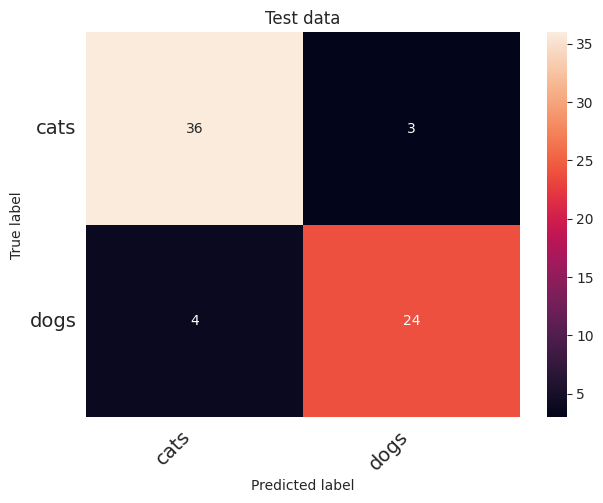

In [36]:
%run '/home/andreylolobrigida/Oficina Data Centric AI/MFCC/scripts/cats_and_dogs_classification.py'